# AAND BCI - Exercise Sheet #05

#### Name: Luke Longren

In [1]:
import numpy as np
import scipy as sp
import scipy.signal
from matplotlib import pyplot as plt

import bci_minitoolbox as bci
import bci_classifiers as cfy    # contains train_LDA, crossvalidation and loss_weighted_error
import bci_classifiers2 as cfy2  # contains cov_shrink, train_LDAshrink

In [2]:
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')
plt.rcParams.update({'font.size': 16})
plt.rcParams["figure.figsize"] = (15, 6)

In [3]:
def proc_spatialFilter(cnt, clab, chan, neighbors='*'):
    '''
    Usage:
        cnt_sf = proc_spatialFilter(cnt, clab, chan, neighbors='*')
    Parameters:
        cnt:       a 2D array of multi-channel timeseries (size: channels x samples),
        clab:      a 1D array of channel names  (size: channels)
        chan:      channel of center location
        neighbors: labels of channels that are to be subtracted 
    Returns:
        cnt_sf:    timeseries of spatially filtered channel (size: 1 x samples)
    Examples:
        cnt_c4_bip = proc_spatialFilter(cnt, clab, 'C4', 'CP4')
        cnt_c4_lap = proc_spatialFilter(cnt, clab, 'C4', ['C2','C6','FC4','CP4'])
        cnt_c4_car = proc_spatialFilter(cnt, clab, 'C4', '*')
    '''
    cidx= clab.index(chan)
    if isinstance(neighbors, list):
        nidx = [clab.index(cc) for cc in neighbors]
    elif neighbors == '*':
        nidx = range(len(clab))   # Common Average Reference (CAR)
    else:
        nidx = [clab.index(neighbors)]
    cnt_sf = cnt[[cidx],:] - np.mean(cnt[nidx,:], axis=0)
    return cnt_sf

## Preparation: Load data

In [4]:
fname = 'imagVPaw.npz'
cnt, fs, clab, mnt, mrk_pos, mrk_class, mrk_className = bci.load_data(fname)
print(cnt.shape, ', shape of the data')

(51, 282838) , shape of the data


## Step 1: Determining a Frequency Band  (Solution provided!)
Calculate the classwise averaged power spectral density at scalp locations C3 and C4 in the data set `imagVPaw`. For each motor imagery condition, you may use the interval 1000-5000 ms.  Determine a frequency band that seems useful to discriminate the two moto imagery conditions.
**Note:** To take into account what was said in the lecture about spectra and spatial filtering, use a bipolar filter for C3 and a Laplace filter for C4. To calculate the average spectra over single trials you can use 

```>>> f, psd = sp.signal.welch(X.flatten('F'), fs=100)```
  
assuming the single trials of one channel to be the columns of `X` and sampled at 100Hz.

In [5]:
def plot_PSD(cnt, fs, mrk_pos, mrk_class, ival):
    epo, _ = bci.makeepochs(cnt, fs, mrk_pos, ival)
    X1 = epo[:, 0, mrk_class==0]
    X2 = epo[:, 0, mrk_class==1]
    f1, X1psd = sp.signal.welch(X1.flatten('F'), fs=fs)
    f2, X2psd = sp.signal.welch(X2.flatten('F'), fs=fs)

    plt.semilogy(f1, X1psd)
    plt.semilogy(f2, X2psd)
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('PSD [$uV^2$/Hz]')

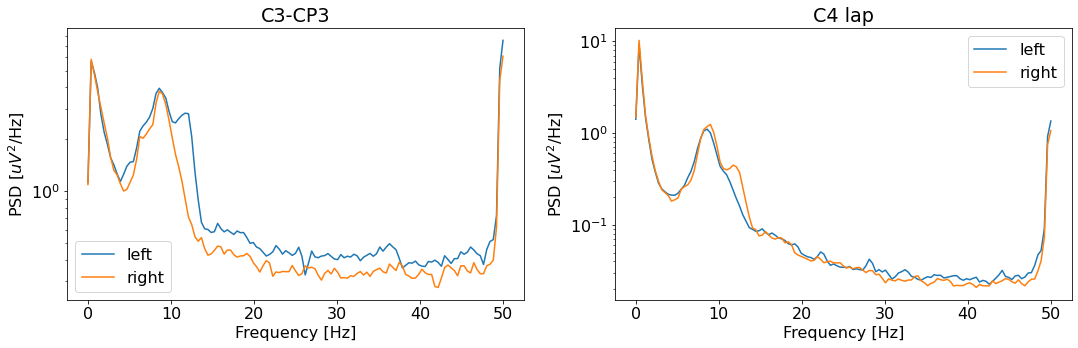

In [6]:
c3 = proc_spatialFilter(cnt, clab, 'C3', 'CP3')
c4 = proc_spatialFilter(cnt, clab, 'C4', ['C2','C6','FC4','CP4'])
clab_flt = ['C3-CP3', 'C4 lap']

plt.figure(figsize=[18, 5])
plt.subplot(121)
plot_PSD(c3, fs, mrk_pos, mrk_class, [1000, 5000])
plt.title(clab_flt[0])
plt.legend(mrk_className)
plt.subplot(122)
plot_PSD(c4, fs, mrk_pos, mrk_class, [1000, 5000])
plt.title(clab_flt[1])
plt.legend(mrk_className)

band = np.array([10.5, 13.]) # "." is crucial!

## Step 2: Visualizing ERD/ERS curves  (Solution provided!)
Design a band-pass filter with the frequency band that was selected in exercises \#1 (use the band `[11. 16.]` if you did not succeed with that, but note that this band may be suboptimal). For the same channels (and spatial filters) as in exercise \#1, calculate and display the classwise averaged ERD/ERS curves with respect to the determined frequency band for the time interval that encompasses a prestimulus interval of 500 ms and extends to 6000 ms poststimulus.

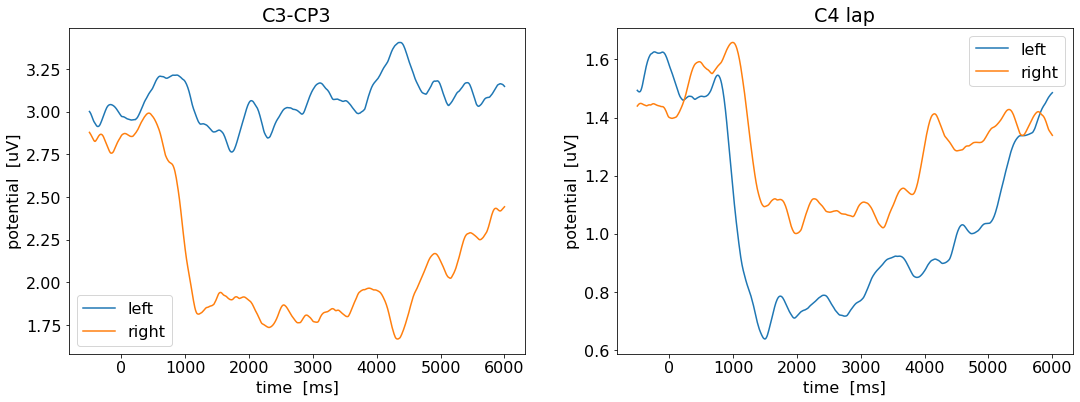

In [7]:
Wn = band / fs * 2
b, a = scipy.signal.butter(5, Wn, btype='bandpass')
cnt_flt = np.concatenate((c3, c4), axis=0)
cnt_flt = sp.signal.lfilter(b, a, cnt_flt)
cnt_hull = np.abs(sp.signal.hilbert(cnt_flt, axis=1))
erd, erd_t = bci.makeepochs(cnt_hull, fs, mrk_pos, [-500, 6000])
# Alternative version without hilbert transform:
#erd, erd_t = bci.makeepochs(cnt_flt, fs, mrk_pos, [-500, 6000])
#erd = np.abs(erd)
erd0 = np.mean(erd[:,:,mrk_class==0], axis=2)
erd1 = np.mean(erd[:,:,mrk_class==1], axis=2)

plt.figure(figsize=[18, 6])
nChans= len(clab_flt)
for i in range(nChans):
    plt.subplot(1, nChans, i+1)
    plt.plot(erd_t, erd0[:, i], label=mrk_className[0])
    plt.plot(erd_t, erd1[:, i], label=mrk_className[1])
    plt.title(clab_flt[i])
    plt.xlabel('time  [ms]')
    plt.ylabel('potential  [uV]')
    plt.legend()

## Exercise 0: Classification of single-trial ERD/ERS curves  (3 BONUS points)
Subsample the band-pass filtered and rectified epochs of the interval 1000 ms to 5000 ms down to 5 Hz by calculating the average of every consequtive window of 200 ms. Perform crossvalidation of those features separately for each single channel and display the result as scalp map. (In this case, do not use a spatial filter.) Furthermore, perform a 3-fold crossvalidation for the joint feature vector (dimensionality is 20 [time points] `x` 51 [channels]).
**Note:** Don't be disappointed if the results are not good. On the next sheet you will implement a powerful method for this case.

## Exercise 1: Common Spatial Pattern Analysis  (5 points)
Apply a band-pass filter to the given (continuous) EEG signals according to the findings in exercises \#1 on the last sheet (or use the reference solution [10.5 13] Hz)} and perform a CSP analysis for the time interval 750-4000 ms. Plot the spatial patterns corresponding to the 3 largest and the 3 smallest eigenvalues as scalp maps. Apply the six spatial filters to the band-pass filtered EEG signals. The resulting signals are subsequently called CSP-filtered signals.

In [8]:
def train_CSP(epo, mrk_class):
    ''' Usage: W, D = train_CSP(epo, mrk_class) '''
    epo1 = epo[:,:, mrk_class == 0]
    epo2 = epo[:,:, mrk_class == 1]
    sigma1 = cfy2.cov_shrink(np.mean(epo1, axis=2).T)
    sigma2 = cfy2.cov_shrink(np.mean(epo2, axis=2).T)
    D, W = sp.linalg.eigh(a=sigma1, b=sigma1+sigma2)
    return W, D

In [9]:
ival = [750, 4000]  # [ms]
# apply a bandpass filter
cnt_filtered = sp.signal.lfilter(b, a, cnt)
cnt_hilbert = np.abs(sp.signal.hilbert(cnt_filtered, axis=1))
cnt_hilbert = cnt
epo, epo_t = bci.makeepochs(cnt_hilbert, fs, mrk_pos, ival)
print(epo.shape, ', (samples x channels x epochs)')

(326, 51, 280) , (samples x channels x epochs)


In [10]:
# perform CPS analysis
W, D = train_CSP(epo, mrk_class)
print(W.shape, D.shape)

(51, 51) (51,)


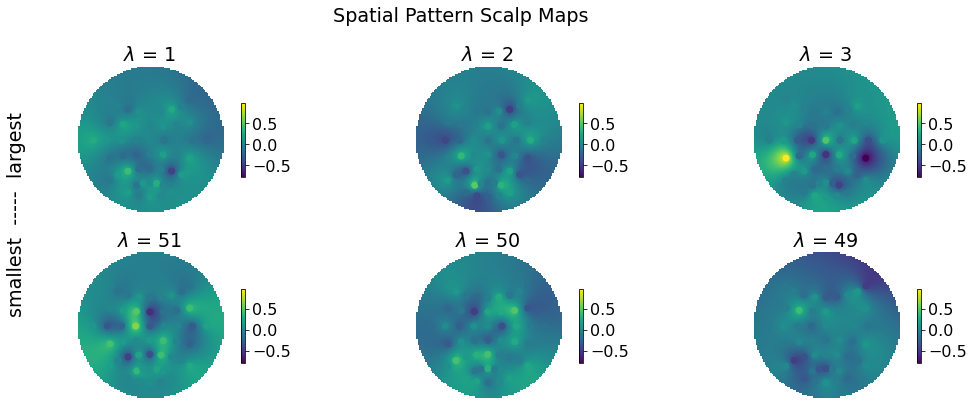

In [11]:
fig = plt.figure()
clim = [np.array([W[:3], W[-3:]]).min(), np.array([W[:3], W[-3:]]).max()]
for i in range(3):
    plt.subplot(2,3,i+1)
    bci.scalpmap(mnt, W[i], clim=clim, cb_label='')
    plt.title('$\lambda$ = {0}'.format(i+1))
    plt.subplot(2,3,i+1+3)
    bci.scalpmap(mnt, W[-(i+1)], clim=clim, cb_label='')
    plt.title('$\lambda$ = {0}'.format(W.shape[0] - i))
plt.suptitle('Spatial Pattern Scalp Maps')
fig.text(0.08, 0.5, 'smallest  -----  largest', va='center', rotation=90, fontsize=plt.rcParams['axes.titlesize'])
plt.tight_layout(rect=[0, 0.03, 1, 0.93])
plt.show()

(51, 51) (51,)


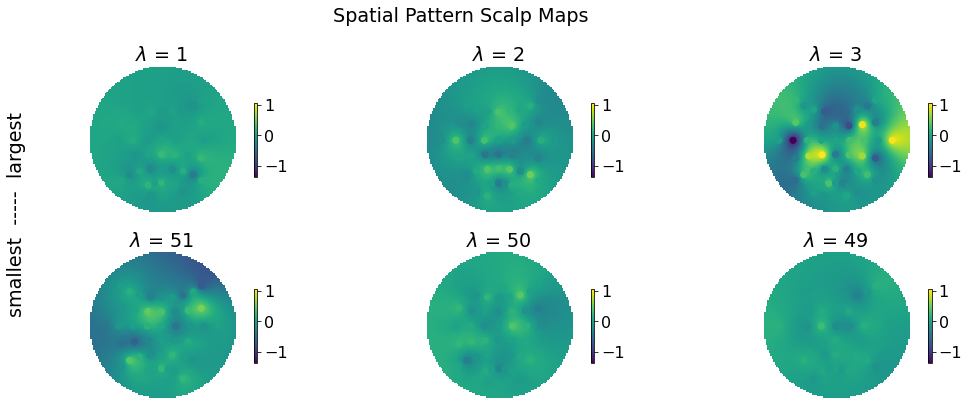

In [12]:
# If you are not sucessful implementing train_CSP, or if you are unsure, you can use results from the provided file:
data = np.load('imagVPaw_csp.npz')
W = data['W']
d = data['d']
print(W.shape, d.shape)

fig = plt.figure()
clim = [np.array([W[:3], W[-3:]]).min(), np.array([W[:3], W[-3:]]).max()]
for i in range(3):
    plt.subplot(2,3,i+1)
    bci.scalpmap(mnt, W[i], clim=clim, cb_label='')
    plt.title('$\lambda$ = {0}'.format(i+1))
    plt.subplot(2,3,i+1+3)
    bci.scalpmap(mnt, W[-(i+1)], clim=clim, cb_label='')
    plt.title('$\lambda$ = {0}'.format(W.shape[0] - i))
plt.suptitle('Spatial Pattern Scalp Maps')
fig.text(0.08, 0.5, 'smallest  -----  largest', va='center', rotation=90, fontsize=plt.rcParams['axes.titlesize'])
plt.tight_layout(rect=[0, 0.03, 1, 0.93])
plt.show()

## Exercise 2:  Visualizing ERD/ERS curves of CSP channels  (1 point)
Take the CSP-filtered signals and visualize the classwise averaged ERD/ERS curves in the 6 channels. (If you did not succeed with exercise \#1, download the file `imagVPaw_csp}` from the web side, which includes the full filter matrix $\bf W$ and Eigenvalues $\bf d$).
Use the time interval from -500 ms to 6000 ms. Determine from these curves a time interval which shows a good discrimination of between the two motor imagery conditions for subsequent tasks.
**Note:** It would be better to use $r^2$-values for this purpose, but we skip that for this exercise.

In [13]:
"""apply CPS to the EEG data"""
cnt_flt = sp.signal.lfilter(b, a, cnt)
cnt_hull = np.abs(sp.signal.hilbert(cnt_flt, axis=1))
erd, erd_t = bci.makeepochs(cnt_hull, fs, mrk_pos, [-500, 6000])
erd0 = np.mean(erd[:,:,mrk_class==0], axis=2)
erd1 = np.mean(erd[:,:,mrk_class==1], axis=2)

# the CPS filtered signals
cnt_CPS = np.zeros((W.shape[0], 2, erd.shape[0]))
for i in range(W.shape[0]):  # loop over channels
    cnt_CPS[i] = np.var(W[i].T * [erd0, erd1], axis=2)
print(cnt_CPS.shape)

(51, 2, 651)


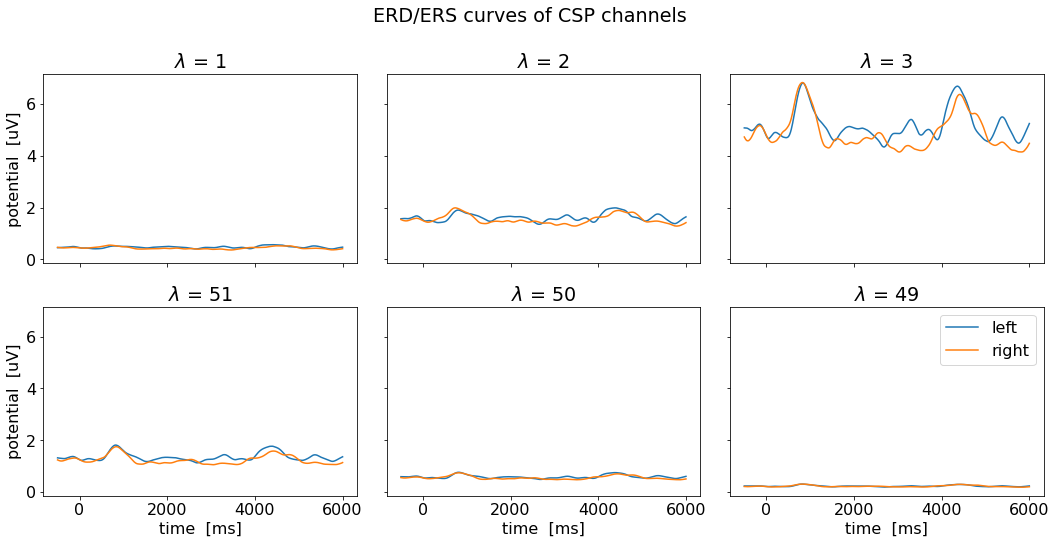

In [14]:
fig, axs = plt.subplots(2, 3, figsize=(15,8), sharex=True, sharey=True)
for i in range(3):
    axs[0,i].plot(erd_t, cnt_CPS[i, 0], label=mrk_className[0])
    axs[0,i].plot(erd_t, cnt_CPS[i, 1], label=mrk_className[1])
    axs[0,i].set_title('$\lambda$ = {0}'.format(i+1))
    axs[1,i].plot(erd_t, cnt_CPS[-(i+1), 0], label=mrk_className[0])
    axs[1,i].plot(erd_t, cnt_CPS[-(i+1), 1], label=mrk_className[1])
    axs[1,i].set_title('$\lambda$ = {0}'.format(W.shape[0] - i))
    axs[1,i].set_xlabel('time  [ms]')
    if i == 0:
        axs[0,i].set_ylabel('potential  [uV]')
        axs[1,i].set_ylabel('potential  [uV]')
plt.suptitle('ERD/ERS curves of CSP channels')
plt.tight_layout(rect=[0, 0.03, 1, 0.93])
plt.legend()
plt.show()

## Exercise 3: Visualization of log power Features  ( 1 point)
Take the CSP-filtered signals, extract single trials in the time interval determined in exercise \#2 (or 750-4000 ms if you did not succeed) and calculate the log variance within each trial. This gives a six dimensional feature vector for each single trial. Select two of those six dimensions for visualization.  Make a scatter plot with the two selected dimensions on the $x$- resp. $y$-axis and use two different colors for the two conditions.
*Optionally, you may add the separation line of an LDA.*

In [15]:
print(cnt_CPS.shape)

(51, 2, 651)


In [16]:
# determine the time interval indices
time_bound = [750, 4000]
time_indices = np.array([])
for i in range(erd_t.size):
    if time_bound[0] <= erd_t[i] <= time_bound[1]:
        time_indices = np.append(time_indices, i)
# calculate the log variance for each
cnt_feature0 = np.log(cnt_CPS[0])
cnt_feature1 = np.log(cnt_CPS[-1])
print(cnt_feature0.shape, cnt_feature1.shape)

(2, 651) (2, 651)


In [17]:
print(cnt_CPS.shape)

(51, 2, 651)


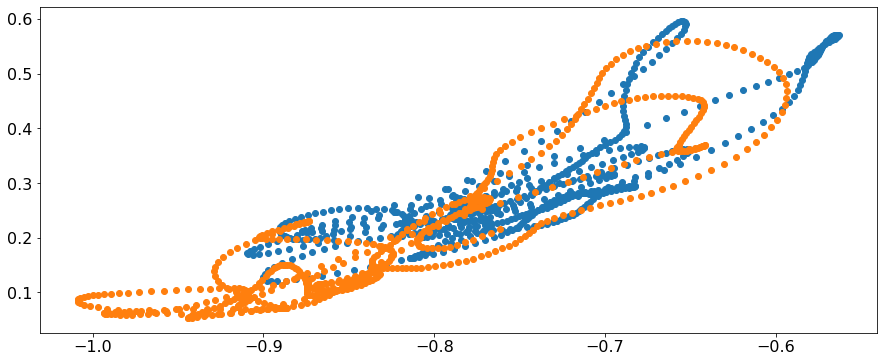

In [18]:
# plotting the lowest and highest eigenvalues against each other
plt.scatter(cnt_feature0[0], cnt_feature1[0])
plt.scatter(cnt_feature0[1], cnt_feature1[1])
plt.show()

Ran out of time to troubleshoot where exactly my *train_CSP* function is going wrong. That, combined with how exactly one should calculate the log variance had me pretty confused in general, despite using the slides and their information. I think my general understanding of what we are doing here is just a bit off.   
Regardless, looking forward to seeing the solution tomorrow. =)

## Exercise 4: Validation of the Classification Procedure  (3 points)
Estimate the generalization error of the whole classification procedure using all 6 feature dimensions. Use the first half of the data as training set and the second half as validation set. *Remember what was said in the lecture about validating a CSP-based method!*

Did not finish.